# Exploratory Data Analysis - version 2 data
IUM projekt - 2021Z

Zadanie 8, wariant 3

Authors: Michał Łątkowski, Vladyslav Kyryk

Task - optimalisation of products ordering for next week by predicting the demand


In [195]:
# Adding autoreload will let you edit your package and see the changes without restarting the notebook.

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [196]:
# !pip install pandas-profiling[notebook]
import pandas as pd
from datetime import datetime
import calendar
from pandas_profiling import ProfileReport

## Data import

In [197]:
deliveries = pd.read_json("../data/raw/second/deliveries.jsonl", lines=True)
products = pd.read_json("../data/raw/second/products.jsonl", lines=True)
sessions = pd.read_json("../data/raw/second/sessions.jsonl", lines=True)
users = pd.read_json("../data/raw/second/users.jsonl", lines=True)

## Data quality analysis in "deliveries" dataset

In [198]:
print("Typy w dataframe")
print(deliveries.dtypes)
print("\nIlosc pustych wartosci na kolumne")
print(deliveries.isna().sum())
deliveries["purchase_timestamp"] = pd.to_datetime(deliveries["purchase_timestamp"])
deliveries["delivery_timestamp"] = pd.to_datetime(deliveries["delivery_timestamp"])
deliveries["delivery_company"] = deliveries["delivery_company"].astype("Int64")
print("\nDataframe po probie konwersji typow")
print(deliveries.dtypes)
print(
    "\nCzy purchase_id to unikalny identyfikator? ",
    pd.Series(deliveries["purchase_id"]).is_unique,
)

Typy w dataframe
purchase_id            int64
purchase_timestamp    object
delivery_timestamp    object
delivery_company       int64
dtype: object

Ilosc pustych wartosci na kolumne
purchase_id           0
purchase_timestamp    0
delivery_timestamp    0
delivery_company      0
dtype: int64

Dataframe po probie konwersji typow
purchase_id                    int64
purchase_timestamp    datetime64[ns]
delivery_timestamp    datetime64[ns]
delivery_company               Int64
dtype: object

Czy purchase_id to unikalny identyfikator?  True


In [199]:
deliveries.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16056 entries, 0 to 16055
Data columns (total 4 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   purchase_id         16056 non-null  int64         
 1   purchase_timestamp  16056 non-null  datetime64[ns]
 2   delivery_timestamp  16056 non-null  datetime64[ns]
 3   delivery_company    16056 non-null  Int64         
dtypes: Int64(1), datetime64[ns](2), int64(1)
memory usage: 517.6 KB


In [200]:
deliveries

purchase_id  purchase_timestamp  delivery_timestamp  delivery_company
0            20001 2019-12-30 14:25:31 2020-01-03 14:28:51               620
1            20002 2019-12-30 17:35:47 2020-01-02 17:38:11               516
2            20003 2019-12-31 15:14:01 2020-01-02 15:16:57               516
3            20004 2019-12-31 14:20:20 2020-01-03 14:24:09               620
4            20005 2019-12-31 04:02:00 2020-01-04 04:05:25               360
...            ...                 ...                 ...               ...
16051        36052 2021-01-01 16:44:14 2021-01-06 16:45:17               360
16052        36053 2021-01-03 17:25:05 2021-01-08 17:29:49               360
16053        36054 2021-01-01 15:28:42 2021-01-03 15:30:55               360
16054        36055 2021-01-01 02:35:51 2021-01-03 02:36:30               620
16055        36056 2021-01-01 01:26:52 2021-01-06 01:28:28               360

[16056 rows x 4 columns]

In [201]:
deliveries['purchase_timestamp'].agg(['min', 'max'])

min   2019-08-01 04:31:06
max   2021-12-20 11:03:23
Name: purchase_timestamp, dtype: datetime64[ns]

In [202]:
deliveries['delivery_company'].value_counts()

360    5424
516    5369
620    5263
Name: delivery_company, dtype: Int64

#### Number of deliveries per month

In [203]:
deliveries['delivery_month'] = deliveries['delivery_timestamp'].dropna().dt.month

<AxesSubplot:>

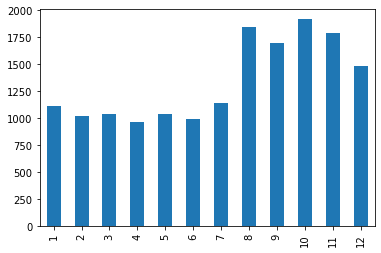

In [204]:
deliveries['delivery_month'].value_counts().sort_index().plot.bar()

## Data quality analysis in "products" dataset

In [205]:
print("Typy w dataframe")
print(products.dtypes)
print("\nIlosc pustych wartosci na kolumne")
print(products.isna().sum())
print(
    "\nCzy product_id to unikalny identyfikator?",
    pd.Series(products["product_id"]).is_unique,
)
print("\nLiczba niedodatnich cen", products["price"][products["price"] <= 0].count())
print("\nProdukty podejrzanie drogie (czesc moze byc poprawna)")
q = products["price"].quantile(0.90)
print(products[products["price"] > q])
print(
    "\nCzy wszystkie wartosci w kolumnie product_name sa stringami?",
    (products["product_name"].apply(type) == str).all(),
)
print(
    "\nCzy wszystkie wartosci w kolumnie category_path sa stringami?",
    (products["category_path"].apply(type) == str).all(),
)

Typy w dataframe
product_id         int64
product_name      object
category_path     object
price            float64
dtype: object

Ilosc pustych wartosci na kolumne
product_id       0
product_name     0
category_path    0
price            0
dtype: int64

Czy product_id to unikalny identyfikator? True

Liczba niedodatnich cen 0

Produkty podejrzanie drogie (czesc moze byc poprawna)
     product_id                                       product_name  \
1          1002                                 Kyocera FS-1135MFP   
2          1003                                 Kyocera FS-3640MFP   
16         1017                                    LCD Dell U2412M   
24         1025                                    LCD BenQ GL2250   
29         1030                                LCD Iiyama B2280WSD   
31         1032                                LCD Iiyama E2280WSD   
32         1033                                LCD Iiyama T1932MSC   
33         1034                                    LCD 

In [206]:
products.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 319 entries, 0 to 318
Data columns (total 4 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   product_id     319 non-null    int64  
 1   product_name   319 non-null    object 
 2   category_path  319 non-null    object 
 3   price          319 non-null    float64
dtypes: float64(1), int64(1), object(2)
memory usage: 10.1+ KB


In [207]:
products

product_id                                    product_name  \
0          1001                   Telefon Siemens Gigaset DA310   
1          1002                              Kyocera FS-1135MFP   
2          1003                              Kyocera FS-3640MFP   
3          1004                            Fallout 3 (Xbox 360)   
4          1005  Szalone Króliki Na żywo i w kolorze (Xbox 360)   
..          ...                                             ...   
314        1315                                      Jabra Talk   
315        1316                      Plantronics Voyager Legend   
316        1317                           Plantronics Savi W740   
317        1318                           Plantronics Savi W710   
318        1319                                     HTC HS-S200   

                                         category_path    price  
0            Telefony i akcesoria;Telefony stacjonarne    58.97  
1    Komputery;Drukarki i skanery;Biurowe urządzeni...  2048.50  
2    Komputery;Drukarki i skanery;Biurowe urządzeni...  7639.00  
3            Gry i konsole;Gry na konsole;Gry Xbox 360    49.99  
4            Gry i konsole;Gry na konsole;Gry Xbox 360    49.99  
..                                                 ...      ...  
314  Telefony i akcesoria;Akcesoria telefoniczne;Ze...    54.99  
315  Telefony i akcesoria;Akcesoria telefoniczne;Ze...   249.00  
316  Telefony i akcesoria;Akcesoria telefoniczne;Ze...  1303.96  
317                         Sprzęt RTV;Audio;Słuchawki   553.00  
318  Telefony i akcesoria;Akcesoria telefoniczne;Ze...    14.99  

[319 rows x 4 columns]

In [208]:
products[products['price'] < 0]

Empty DataFrame
Columns: [product_id, product_name, category_path, price]
Index: []

In [209]:
products[products['price'] > 5000].sort_values(by='price')

product_id        product_name  \
77        1078  Kyocera FS-3540MFP   
80        1081          OKI B840dn   
79        1080  Kyocera FS-3140MFP   
2         1003  Kyocera FS-3640MFP   

                                        category_path   price  
77  Komputery;Drukarki i skanery;Biurowe urządzeni...  5126.0  
80  Komputery;Drukarki i skanery;Biurowe urządzeni...  5259.0  
79  Komputery;Drukarki i skanery;Biurowe urządzeni...  5301.9  
2   Komputery;Drukarki i skanery;Biurowe urządzeni...  7639.0

In [210]:
products['category_path'].value_counts()

Gry i konsole;Gry komputerowe                                        202
Gry i konsole;Gry na konsole;Gry Xbox 360                             32
Sprzęt RTV;Video;Telewizory i akcesoria;Anteny RTV                    30
Komputery;Monitory;Monitory LCD                                       17
Komputery;Drukarki i skanery;Biurowe urządzenia wielofunkcyjne         9
Gry i konsole;Gry na konsole;Gry PlayStation3                          9
Telefony i akcesoria;Akcesoria telefoniczne;Zestawy głośnomówiące      5
Telefony i akcesoria;Akcesoria telefoniczne;Zestawy słuchawkowe        4
Telefony i akcesoria;Telefony komórkowe                                2
Sprzęt RTV;Video;Odtwarzacze DVD                                       2
Komputery;Tablety i akcesoria;Tablety                                  2
Sprzęt RTV;Przenośne audio i video;Odtwarzacze mp3 i mp4               2
Telefony i akcesoria;Telefony stacjonarne                              1
Sprzęt RTV;Video;Telewizory i akcesoria;Okulary 3D 

In [211]:
products['main_category'] = products['category_path'].apply(lambda x: x.split(';')[0])
products['main_category'].value_counts()

Gry i konsole           243
Sprzęt RTV               36
Komputery                28
Telefony i akcesoria     12
Name: main_category, dtype: int64

In [212]:
products['second_category'] = products['category_path'].apply(lambda x: x.split(';')[1])
products['second_category'].value_counts()

Gry komputerowe            202
Gry na konsole              41
Video                       33
Monitory                    17
Drukarki i skanery           9
Akcesoria telefoniczne       9
Telefony komórkowe           2
Tablety i akcesoria          2
Przenośne audio i video      2
Telefony stacjonarne         1
Audio                        1
Name: second_category, dtype: int64

#### Min/max price in each category

In [213]:
products[['category_path', 'price']].groupby(by='category_path').agg(['min', 'max'])

price         
                                                        min      max
category_path                                                       
Gry i konsole;Gry komputerowe                          1.00   199.90
Gry i konsole;Gry na konsole;Gry PlayStation3         59.90   129.00
Gry i konsole;Gry na konsole;Gry Xbox 360             14.99   139.99
Komputery;Drukarki i skanery;Biurowe urządzenia...  1998.14  7639.00
Komputery;Monitory;Monitory LCD                      269.00  3029.00
Komputery;Tablety i akcesoria;Tablety               1816.97  2317.02
Sprzęt RTV;Audio;Słuchawki                           553.00   553.00
Sprzęt RTV;Przenośne audio i video;Odtwarzacze ...    64.80    78.90
Sprzęt RTV;Video;Odtwarzacze DVD                     109.00   193.00
Sprzęt RTV;Video;Telewizory i akcesoria;Anteny RTV    29.99   219.00
Sprzęt RTV;Video;Telewizory i akcesoria;Okulary 3D    99.99    99.99
Telefony i akcesoria;Akcesoria telefoniczne;Zes...    86.28   327.47
Telefony i akcesoria;Akcesoria telefoniczne;Zes...    14.99  1303.96
Telefony i akcesoria;Telefony komórkowe              207.33  2199.90
Telefony i akcesoria;Telefony stacjonarne             58.97    58.97

## Data quality analysis in "sessions" dataset

In [214]:
print("Typy w dataframe")
print(sessions.dtypes)
print("\nIlosc pustych wartosci na kolumne")
print(sessions.isna().sum())
sessions["user_id"] = sessions["user_id"].astype("Int64")
sessions["product_id"] = sessions["product_id"].astype("Int64")
sessions["purchase_id"] = sessions["purchase_id"].astype("Int64")
print("\nDataframe po probie konwersji typow")
print(sessions.dtypes)

Typy w dataframe
session_id                   int64
timestamp           datetime64[ns]
user_id                      int64
product_id                   int64
event_type                  object
offered_discount             int64
purchase_id                float64
dtype: object

Ilosc pustych wartosci na kolumne
session_id               0
timestamp                0
user_id                  0
product_id               0
event_type               0
offered_discount         0
purchase_id         771189
dtype: int64

Dataframe po probie konwersji typow
session_id                   int64
timestamp           datetime64[ns]
user_id                      Int64
product_id                   Int64
event_type                  object
offered_discount             int64
purchase_id                  Int64
dtype: object


In [215]:
sessions.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 787245 entries, 0 to 787244
Data columns (total 7 columns):
 #   Column            Non-Null Count   Dtype         
---  ------            --------------   -----         
 0   session_id        787245 non-null  int64         
 1   timestamp         787245 non-null  datetime64[ns]
 2   user_id           787245 non-null  Int64         
 3   product_id        787245 non-null  Int64         
 4   event_type        787245 non-null  object        
 5   offered_discount  787245 non-null  int64         
 6   purchase_id       16056 non-null   Int64         
dtypes: Int64(3), datetime64[ns](1), int64(2), object(1)
memory usage: 44.3+ MB


In [216]:
sessions['timestamp'].agg(['min', 'max'])

min   2019-08-01 00:16:17
max   2021-12-20 11:03:23
Name: timestamp, dtype: datetime64[ns]

In [217]:
sessions[['event_type']].value_counts()

event_type  
VIEW_PRODUCT    771189
BUY_PRODUCT      16056
dtype: int64

In [218]:
buy_sessions = sessions[sessions['event_type'] == 'BUY_PRODUCT']

In [219]:
buy_sessions.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 16056 entries, 132 to 787205
Data columns (total 7 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   session_id        16056 non-null  int64         
 1   timestamp         16056 non-null  datetime64[ns]
 2   user_id           16056 non-null  Int64         
 3   product_id        16056 non-null  Int64         
 4   event_type        16056 non-null  object        
 5   offered_discount  16056 non-null  int64         
 6   purchase_id       16056 non-null  Int64         
dtypes: Int64(3), datetime64[ns](1), int64(2), object(1)
memory usage: 1.0+ MB


In [220]:
sessions['product_id'].nunique()

197

In [221]:
buy_sessions['product_id'].nunique()

197

### Histogram which shows how many times products were sold

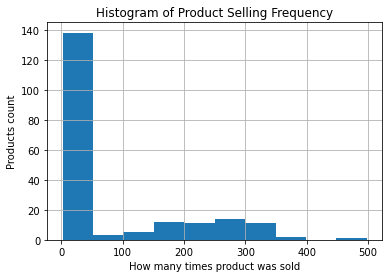

In [222]:
import pylab as pl

num_of_each_product_sold = buy_sessions['product_id'].value_counts().to_frame().reset_index().rename(columns={'product_id': 'sold_count', 'index': 'product_id'})

num_of_each_product_sold.hist(column='sold_count')
pl.title("Histogram of Product Selling Frequency")
pl.xlabel("How many times product was sold")
pl.ylabel("Products count")
pl.savefig('hist.png')

In [223]:
pd.cut(num_of_each_product_sold['sold_count'], bins=20).value_counts()

(1.504, 26.8]     117
(26.8, 51.6]       21
(150.8, 175.6]      8
(274.8, 299.6]      8
(200.4, 225.2]      7
(299.6, 324.4]      6
(250.0, 274.8]      6
(126.0, 150.8]      5
(324.4, 349.2]      5
(175.6, 200.4]      4
(225.2, 250.0]      4
(51.6, 76.4]        2
(76.4, 101.2]       1
(349.2, 374.0]      1
(374.0, 398.8]      1
(473.2, 498.0]      1
(101.2, 126.0]      0
(398.8, 423.6]      0
(423.6, 448.4]      0
(448.4, 473.2]      0
Name: sold_count, dtype: int64

In [224]:
num_of_each_product_sold[num_of_each_product_sold['sold_count'] < 50]

product_id  sold_count
59         1069          49
60         1065          43
61         1064          42
62         1066          41
63         1071          37
..          ...         ...
192        1151           3
193        1157           3
194        1158           3
195        1163           2
196        1105           2

[138 rows x 2 columns]

### Number of sessions over different time periods

#### Number of all sessions per month

In [225]:
sessions['session_month'] = sessions['timestamp'].dropna().dt.month

<AxesSubplot:>

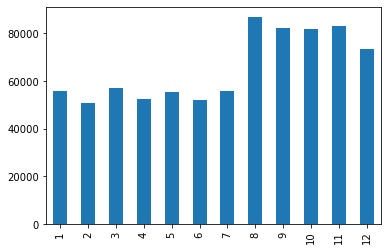

In [226]:
sessions['session_month'].value_counts().sort_index().plot.bar()

#### Number of buy_product sessions per month

In [227]:
buy_sessions['session_month'] = buy_sessions['timestamp'].dropna().dt.month

/tmp/ipykernel_28794/1442752891.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  buy_sessions['session_month'] = buy_sessions['timestamp'].dropna().dt.month


<AxesSubplot:>

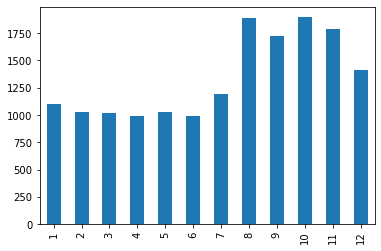

In [228]:
buy_sessions['session_month'].value_counts().sort_index().plot.bar()

#### Number of all sessions per week

In [229]:
sessions['session_week'] = sessions['timestamp'].dropna().dt.week

/tmp/ipykernel_28794/3713943274.py:1: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week instead.
  sessions['session_week'] = sessions['timestamp'].dropna().dt.week


<AxesSubplot:>

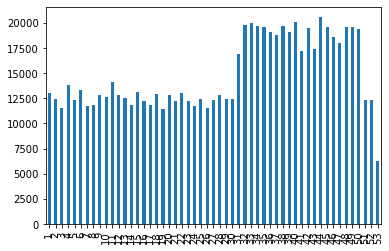

In [230]:
sessions['session_week'].value_counts().sort_index().plot.bar()

#### Number of buy_product sessions per week

In [231]:
buy_sessions['session_week'] = buy_sessions['timestamp'].dropna().dt.week

/tmp/ipykernel_28794/280403240.py:1: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week instead.
  buy_sessions['session_week'] = buy_sessions['timestamp'].dropna().dt.week
/tmp/ipykernel_28794/280403240.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  buy_sessions['session_week'] = buy_sessions['timestamp'].dropna().dt.week


<AxesSubplot:>

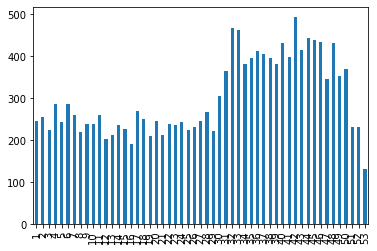

In [232]:
buy_sessions['session_week'].value_counts().sort_index().plot.bar()

#### Number of all sessions per weekday

In [233]:
sessions['session_weekday'] = sessions['timestamp'].dropna().dt.weekday

<AxesSubplot:>

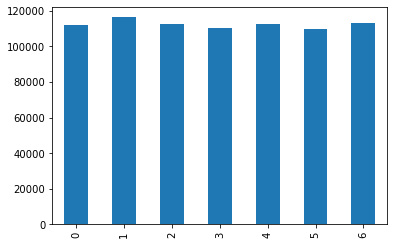

In [234]:
sessions['session_weekday'].value_counts().sort_index().plot.bar()

#### Number of buy_product sessions per weekday

In [235]:
buy_sessions['session_weekday'] = buy_sessions['timestamp'].dropna().dt.weekday

/tmp/ipykernel_28794/2681664498.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  buy_sessions['session_weekday'] = buy_sessions['timestamp'].dropna().dt.weekday


<AxesSubplot:>

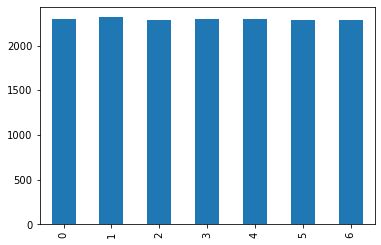

In [236]:
buy_sessions['session_weekday'].value_counts().sort_index().plot.bar()

### How many clients bought 1 product, how many bought 2 products, and so on...

<AxesSubplot:xlabel='number of products user bought', ylabel='number of users'>

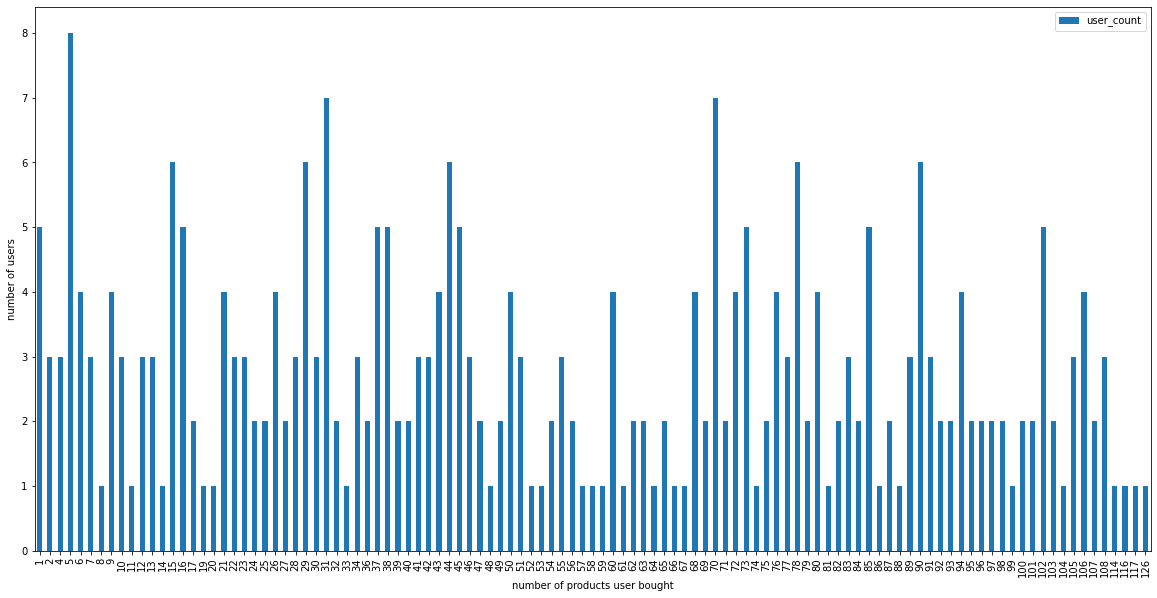

In [237]:
prod_count_per_user = buy_sessions[['product_id', 'user_id']].dropna().groupby(by='user_id', as_index=False).count().rename(columns={'product_id': 'product_count'})
user_count_per_prod_count = prod_count_per_user.groupby(by='product_count').count().rename(columns={'user_id': 'user_count'})
user_count_per_prod_count.plot.bar(figsize=(20, 10), ylabel='number of users', xlabel='number of products user bought')

## Data quality analysis in "users" dataset

In [238]:
print("Typy w dataframe")
print(users.dtypes)
print("\nIlosc pustych wartosci na kolumne")
print(users.isna().sum())
print("\nCzy user_id to unikalny identyfikator?", pd.Series(users["user_id"]).is_unique)
print(
    "\nCzy wszystkie wartosci w kolumnie name sa stringami?",
    (users["name"].apply(type) == str).all(),
)
print(
    "\nCzy wszystkie wartosci w kolumnie city sa stringami?",
    (users["city"].apply(type) == str).all(),
)
print(
    "\nCzy wszystkie wartosci w kolumnie street sa stringami?",
    (users["street"].apply(type) == str).all(),
)

Typy w dataframe
user_id     int64
name       object
city       object
street     object
dtype: object

Ilosc pustych wartosci na kolumne
user_id    0
name       0
city       0
street     0
dtype: int64

Czy user_id to unikalny identyfikator? True

Czy wszystkie wartosci w kolumnie name sa stringami? True

Czy wszystkie wartosci w kolumnie city sa stringami? True

Czy wszystkie wartosci w kolumnie street sa stringami? True


In [239]:
users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 300 entries, 0 to 299
Data columns (total 4 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   user_id  300 non-null    int64 
 1   name     300 non-null    object
 2   city     300 non-null    object
 3   street   300 non-null    object
dtypes: int64(1), object(3)
memory usage: 9.5+ KB


In [240]:
users

user_id               name      city                street
0        102  Patryk Wincenciak  Szczecin      aleja Górska 389
1        103       Filip Młocek   Wrocław       ul. Lelewela 88
2        104  Maurycy Pasieczna   Wrocław   aleja Konwaliowa 78
3        105       Eliza Gieroń     Radom        ul. Kossaka 12
4        106    Łukasz Ciepluch     Radom  aleja Środkowa 72/57
..       ...                ...       ...                   ...
295      397   Sylwia Wąsiewicz   Wrocław   plac Kolejowa 29/17
296      398    Fryderyk Trawka     Radom   ulica Kossaka 98/14
297      399        Marika Ryfa  Warszawa      plac Jagodowa 87
298      400   Adam Łuczkiewicz   Wrocław    ulica Jaskółcza 59
299      401        Paweł Nóżka    Kraków     pl. Perłowa 96/88

[300 rows x 4 columns]

In [241]:
users['city'].value_counts()

Gdynia      51
Radom       48
Szczecin    46
Wrocław     45
Poznań      40
Kraków      39
Warszawa    31
Name: city, dtype: int64

## Reports generated using pandas-profiling

In [242]:
profile_deliveries = ProfileReport(deliveries, title="Raport nt. jakości zbioru deliveries")
profile_deliveries.to_notebook_iframe()
profile_deliveries.to_file("../reports/profile_deliveries.html")

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

Export report to file:   0%|          | 0/1 [00:00<?, ?it/s]

In [243]:
profile_products = ProfileReport(products, title="Raport nt. jakości zbioru products")
profile_products.to_notebook_iframe()
profile_products.to_file("../reports/profile_products.html")

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

Export report to file:   0%|          | 0/1 [00:00<?, ?it/s]

In [244]:
profile_sessions = ProfileReport(sessions, title="Raport nt. jakości zbioru sessions")
profile_sessions.to_notebook_iframe()
profile_sessions.to_file("../reports/profile_sessions.html")

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

Export report to file:   0%|          | 0/1 [00:00<?, ?it/s]

In [245]:
profile_users = ProfileReport(users, title="Raport nt. jakości zbioru users")
profile_users.to_notebook_iframe()
profile_users.to_file("../reports/profile_users.html")

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

Export report to file:   0%|          | 0/1 [00:00<?, ?it/s]